In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Function to save datasets for k-fold cross validation
def save_k_fold_data(df, start_year, fold_sizes, name, folder):
    initial_year = start_year
    for size in fold_sizes:
        # Calculate the end year for the training period directly from the size of the training period
        train_end_year = initial_year + size[0] - 1
        test_end_year = train_end_year + size[1]  # Test period follows immediately after the training period
        
        # Select the training and testing data based on calculated years
        df_train = df[(df.index.year >= initial_year) & (df.index.year <= train_end_year)]
        df_test = df[(df.index.year > train_end_year) & (df.index.year <= test_end_year)]
        
        # Save the datasets to CSV files
        df_train.to_csv(f'{folder}{name}_Train_KFold_{initial_year}_{train_end_year}.csv', index=True)
        df_test.to_csv(f'{folder}{name}_Test_KFold_{train_end_year + 1}_{test_end_year}.csv', index=True)

# Function to save datasets for block cross validation
def save_block_data(df, start_year, block_sizes, name, folder):
    for i, size in enumerate(block_sizes):
        end_year = start_year + size - 1
        if i % 2 == 0:  # Training block
            df_train = df[(df.index.year >= start_year) & (df.index.year <= end_year)]
            df_train.to_csv(f'{folder}{name}_Train_Block_{start_year}_{end_year}.csv', index=True)
        else:  # Testing block
            df_test = df[(df.index.year >= start_year) & (df.index.year <= end_year)]
            df_test.to_csv(f'{folder}{name}_Test_Block_{start_year}_{end_year}.csv', index=True)
        start_year = end_year + 1

In [3]:
# Define filepath
name = 'CF'
folder = 'Data/Mississippi/'
file_path = 'Data/Mississippi/Clark_Fork_1929.txt' 
gauge_num = '82009_00060_00003' # '42785_00060_00003' for Clinton, '224327_00060_00003' for Keokuk, '10977_00060_00003' for AR, '82009_00060_00003' for Clark Fork
skip_rows = 28 #29 for MS gauges, 28 for AR, CF
first_val = True # False for MS gauges, true for AR, CF
predict_cut_off_year = 2002 # 1987 for Clinton, 2003 for AR, 2002 for CF

# Directories for CV
k_fold_dir = folder + 'KFold/'
block_dir = folder + 'Block/'

In [4]:
# load the data with explicit date parsing
df = pd.read_csv(file_path, delimiter='\t', parse_dates=['datetime'], skiprows=skip_rows)

# get rid of the first value if necessary
if first_val:
    df = df[1:]

# Filter the DataFrame to keep only the required columns ('datetime' and '224327_00060_00003')
df = df[['datetime', gauge_num]].copy()

# Renaming '224327_00060_00003' to 'discharge_cfs'
df.rename(columns={gauge_num: 'discharge_cfs'}, inplace=True)

# Convert the 'discharge_cfs' column to numeric, errors='coerce' will set non-numeric values to NaN
df['discharge_cfs'] = pd.to_numeric(df['discharge_cfs'], errors='coerce')

# Set 'datetime' as the index
df.set_index('datetime', inplace=True)

# Removing any non-numeric rows if they exist
df = df[pd.to_numeric(df['discharge_cfs'], errors='coerce').notnull()]

# Convert the index to a DatetimeIndex explicitly
df.index = pd.to_datetime(df.index)

# Display the first few rows of the reloaded and filtered dataframe
df.head()

# Define the file path where you want to save the CSV
output_file_path = file_path[:-4] + '.csv'

# Save the DataFrame to a CSV
df.to_csv(output_file_path, index=True)

# 1. Identify the Range of Years
start_year = df.index.year.min()
end_year = df.index.year.max()

# 2. Calculate the Cut-off Year
total_years = end_year - start_year + 1
train_years = round(total_years * 0.75)  # Approximately 75% of the data for training

cut_off_year = start_year + train_years

# 3. Split the Dataset
# Note: Ensure your DataFrame is sorted by date if it's not already
df_train = df[df.index.year < cut_off_year]
df_test = df[df.index.year >= cut_off_year]

df_train.to_csv(folder+name+'_Train.csv', index=True)
df_test.to_csv(folder+name+'_Test.csv', index=True)

# 4. Save Predictable Data
df_train_predict = df[df.index.year < predict_cut_off_year]
df_test_predict = df[df.index.year >= predict_cut_off_year]

df_train_predict.to_csv(folder+name+'_Predictable_Train.csv', index=True)
df_test_predict.to_csv(folder+name+'_Predictable_Test.csv', index=True)

# Save k-fold cross validation data
k_fold_sizes = [(60, 20), (80, 20), (100, 20), (120, 20)]
save_k_fold_data(df, start_year, k_fold_sizes, name, k_fold_dir)

# Save block cross validation data
block_sizes = [40, 10, 40, 10, 40, 10]
save_block_data(df, start_year, block_sizes, name, block_dir)

/tmp/ipykernel_1566/2681344561.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, delimiter='\t', parse_dates=['datetime'], skiprows=skip_rows)


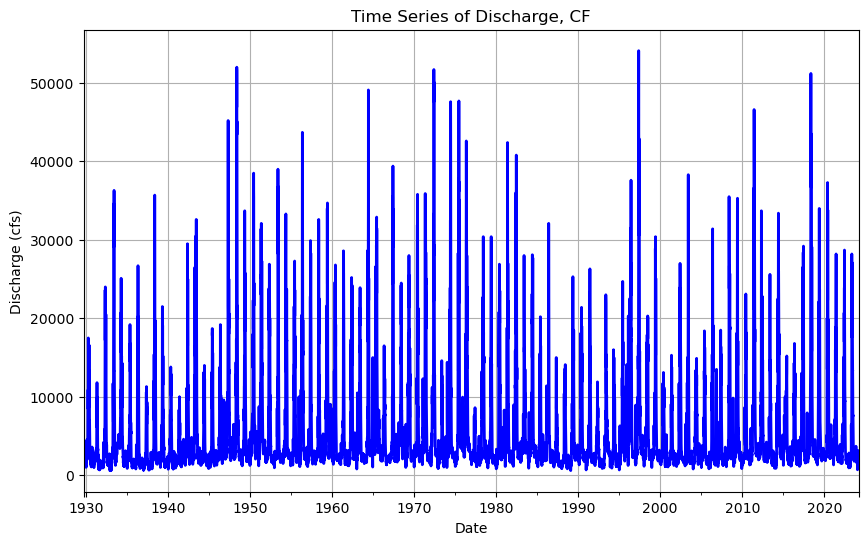

In [5]:
# Plotting the time series
df['discharge_cfs'].plot(figsize=(10, 6), color='blue', linewidth=2)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Discharge (cfs)')
plt.title(f'Time Series of Discharge, {name}')

# Adding grid
plt.grid(True)

# Displaying the plot
plt.show()
